Enter starting room name/number:  Dental
Enter destination room name/number:  Valet Pick Up


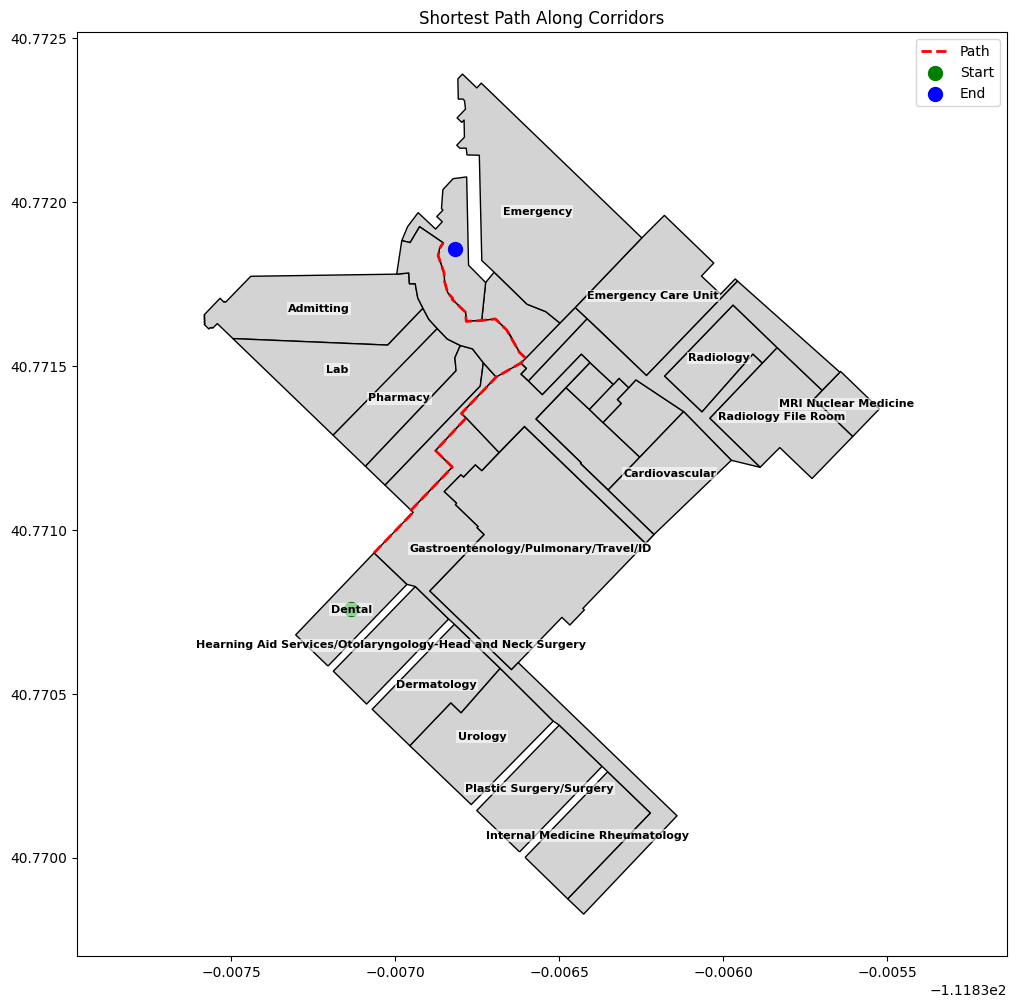

In [60]:
import geopandas as gpd 
import matplotlib.pyplot as plt 
import shapely.geometry
from shapely.geometry import LineString,Point
import networkx as nx 

gdf=gpd.read_file("Level_1_final_final_final.geojson")
room_type="Room Type"
room_no="Room No"
rooms=gdf[~gdf[room_type].str.startswith("c",na=False)]
corridors=gdf[gdf[room_type].str.startswith("c",na=False)]

start_room=input("Enter starting room name/number: ").strip()
end_room=input("Enter destination room name/number: ").strip()

start_geom=rooms[(rooms[room_type]==start_room)|(rooms[room_no]==start_room)].geometry
end_geom=rooms[(rooms[room_type]==end_room)|(rooms[room_no]==end_room)].geometry

if start_geom.empty or end_geom.empty:
    raise ValueError("One of the rooms not found in data!")
    
start_centroid = start_geom.iloc[0].centroid
end_centroid = end_geom.iloc[0].centroid

corridors=corridors.boundary

G=nx.Graph()
for geom in corridors:
    if geom.is_empty:
        continue
    if geom.geom_type=="LineString":
        coords=list(geom.coords)
        for i in range(len(coords)-1):
         p1,p2=Point(coords[i]),Point(coords[i+1])
         G.add_edge((p1.x, p1.y), (p2.x, p2.y), weight=p1.distance(p2))  
    elif geom.geom_type == "MultiLineString":
        for part in geom.geoms:
            coords = list(part.coords)
            for i in range(len(coords) - 1):
                p1, p2 = Point(coords[i]), Point(coords[i + 1])
                G.add_edge((p1.x, p1.y), (p2.x, p2.y), weight=p1.distance(p2))

def connect_to_corridor(point):
    nearest=None
    min_dist=float("inf")
    for node in G.nodes:
        node_point=Point(node)
        d=point.distance(node_point)
        if d<min_dist:
            min_dist=d
            nearest=node
    return nearest
    
start_node=connect_to_corridor(start_centroid)
end_node=connect_to_corridor(end_centroid)

if start_node is None or end_node is None:
    raise ValueError("No node found")

if nx.has_path(G, start_node, end_node):
    path_coords=nx.shortest_path(G, source=start_node, target=end_node, weight="weight")
else:
    path_coords=[start_node]  

if len(path_coords) < 2:
    x, y = path_coords[0]
    offset = 0.1 
    path_coords.append((x + offset, y + offset))

path_line = LineString(path_coords)


fig, ax = plt.subplots(figsize=(12, 12))


gdf.plot(ax=ax, color="lightgrey", edgecolor="black")


x, y = path_line.xy
ax.plot(x, y, color="red", linewidth=2, linestyle="--", label="Path")


ax.scatter(start_centroid.x, start_centroid.y, color="green", s=100, label="Start")
ax.scatter(end_centroid.x, end_centroid.y, color="blue", s=100, label="End")


for _, row in gdf.iterrows():
    geom = row.geometry
    if geom.is_empty:
        continue
    c = geom.centroid
    if row[room_no] and not str(row[room_no]).startswith("c"):
        ax.text(
            c.x, c.y, str(row[room_type]),
            fontsize=8, fontweight="bold", color="black",
            ha="center", va="center",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1)
        )

ax.legend()
plt.title("Shortest Path Along Corridors")
plt.axis("equal")
plt.show()